# Lab | Hypothesis Testing

**Objective**

Welcome to the Hypothesis Testing Lab, where we embark on an enlightening journey through the realm of statistical decision-making! In this laboratory, we delve into various scenarios, applying the powerful tools of hypothesis testing to scrutinize and interpret data.

From testing the mean of a single sample (One Sample T-Test), to investigating differences between independent groups (Two Sample T-Test), and exploring relationships within dependent samples (Paired Sample T-Test), our exploration knows no bounds. Furthermore, we'll venture into the realm of Analysis of Variance (ANOVA), unraveling the complexities of comparing means across multiple groups.

So, grab your statistical tools, prepare your hypotheses, and let's embark on this fascinating journey of exploration and discovery in the world of hypothesis testing!

**Challenge 1**

In this challenge, we will be working with pokemon data. The data can be found here:

- https://raw.githubusercontent.com/data-bootcamp-v4/data/main/pokemon.csv

In [8]:
#libraries
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy import stats


In [9]:
df = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/pokemon.csv")
df

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...
795,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


- We posit that Pokemons of type Dragon have, on average, more HP stats than Grass. Choose the propper test and, with 5% significance, comment your findings.

In [10]:
# Groups: Type 1 OR Type 2 matches
is_dragon = (df["Type 1"].eq("Dragon")) | (df["Type 2"].eq("Dragon"))
is_grass  = (df["Type 1"].eq("Grass"))  | (df["Type 2"].eq("Grass"))

hp_dragon = df.loc[is_dragon, "HP"].dropna()
hp_grass  = df.loc[is_grass,  "HP"].dropna()

# Welch t-test (two-tailed first)
t_stat, p_two = stats.ttest_ind(hp_dragon, hp_grass, equal_var=False)

# Convert to one-tailed for alternative: mean(Dragon) > mean(Grass)
diff = hp_dragon.mean() - hp_grass.mean()
p_one = p_two / 2 if diff > 0 else 1 - p_two / 2

print(f"n (Dragon, Grass): {len(hp_dragon)}, {len(hp_grass)}")
print(f"Mean HP (Dragon, Grass): {hp_dragon.mean():.2f}, {hp_grass.mean():.2f}")
print(f"Welch t = {t_stat:.3f}")
print(f"One-tailed p (Dragon > Grass) = {p_one:.4g}")

alpha = 0.05
print("Decision @ 5%:", 
      "Reject H0 (evidence Dragons have higher HP)" if (p_one < alpha and diff > 0) 
      else "Fail to reject H0 (not enough evidence)")



n (Dragon, Grass): 50, 95
Mean HP (Dragon, Grass): 82.90, 66.05
Welch t = 4.098
One-tailed p (Dragon > Grass) = 5.091e-05
Decision @ 5%: Reject H0 (evidence Dragons have higher HP)


- We posit that Legendary Pokemons have different stats (HP, Attack, Defense, Sp.Atk, Sp.Def, Speed) when comparing with Non-Legendary. Choose the propper test and, with 5% significance, comment your findings.


In [11]:
from math import sqrt

stats_cols = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]

leg = df[df["Legendary"] == True]
non = df[df["Legendary"] == False]

def hedges_g(a, b):
    # unbiased standardized mean difference (like Cohen's d with small-sample correction)
    na, nb = len(a), len(b)
    sa2, sb2 = np.var(a, ddof=1), np.var(b, ddof=1)
    # pooled SD with unequal n (still used for effect size, not for test)
    s_pooled = sqrt(((na-1)*sa2 + (nb-1)*sb2) / (na+nb-2))
    d = (np.mean(a) - np.mean(b)) / s_pooled
    J = 1 - (3/(4*(na+nb)-9))  # small sample correction
    return J * d

rows = []
for col in stats_cols:
    a = leg[col].dropna()
    b = non[col].dropna()
    t, p_two = stats.ttest_ind(a, b, equal_var=False)  # Welch
    g = hedges_g(a, b)
    rows.append({
        "Stat": col,
        "Mean Legendary": a.mean(),
        "Mean Non-Legendary": b.mean(),
        "Welch t": t,
        "p (two-sided)": p_two,
        "Hedges g (Leg − Non)": g,
        "n_Leg": len(a),
        "n_Non": len(b),
    })

res = pd.DataFrame(rows).sort_values("p (two-sided)").reset_index(drop=True)
res


,Stat,Mean Legendary,Mean Non-Legendary,Welch t,p (two-sided),Hedges g (Leg − Non),n_Leg,n_Non
0,Sp. Atk,122.184615,68.454422,13.417450,1.551461e-21,1.834685,65,735
1,Speed,100.184615,65.455782,11.475044,1.049016e-18,1.262463,65,735
2,Attack,116.676923,75.669388,10.438134,2.520372e-16,1.344181,65,735
3,Sp. Def,105.938462,68.892517,10.015697,2.294933e-15,1.426976,65,735
4,HP,92.738462,67.182313,8.981370,1.002691e-13,1.038922,65,735
5,Defense,99.661538,71.559184,7.637078,4.826998e-11,0.928401,65,735


In [12]:
m = len(res)
p = res["p (two-sided)"].values
order = np.argsort(p)
ranked_p = p[order]
bh_thresholds = 0.05 * (np.arange(1, m+1) / m)
bh_significant_mask = ranked_p <= bh_thresholds
# largest index that satisfies the condition
k = np.where(bh_significant_mask)[0].max()+1 if bh_significant_mask.any() else 0
p_bh_crit = ranked_p[k-1] if k>0 else np.nan

res["BH q=0.05 significant?"] = res["p (two-sided)"] <= (0.05 * (res.index+1) / m)
print("Benjamini–Hochberg critical p (max rejected) at q=0.05:", p_bh_crit)
res


Benjamini–Hochberg critical p (max rejected) at q=0.05: 4.826998494919331e-11


,Stat,Mean Legendary,Mean Non-Legendary,Welch t,p (two-sided),Hedges g (Leg − Non),n_Leg,n_Non,BH q=0.05 significant?
0,Sp. Atk,122.184615,68.454422,13.417450,1.551461e-21,1.834685,65,735,True
1,Speed,100.184615,65.455782,11.475044,1.049016e-18,1.262463,65,735,True
2,Attack,116.676923,75.669388,10.438134,2.520372e-16,1.344181,65,735,True
3,Sp. Def,105.938462,68.892517,10.015697,2.294933e-15,1.426976,65,735,True
4,HP,92.738462,67.182313,8.981370,1.002691e-13,1.038922,65,735,True
5,Defense,99.661538,71.559184,7.637078,4.826998e-11,0.928401,65,735,True


In [13]:
# Neat printout of conclusions
alpha = 0.05
for _, r in res.iterrows():
    direction = "higher" if r["Hedges g (Leg − Non)"] > 0 else "lower"
    sig = "SIGNIFICANT" if r["BH q=0.05 significant?"] else "ns"
    print(f"{r['Stat']:<8} | mean Leg={r['Mean Legendary']:.2f}, "
          f"mean Non={r['Mean Non-Legendary']:.2f} | t={r['Welch t']:.2f}, "
          f"p={r['p (two-sided)']:.3g} | g={r['Hedges g (Leg − Non)']:.2f} ({direction}) | {sig}")


Sp. Atk  | mean Leg=122.18, mean Non=68.45 | t=13.42, p=1.55e-21 | g=1.83 (higher) | SIGNIFICANT
Speed    | mean Leg=100.18, mean Non=65.46 | t=11.48, p=1.05e-18 | g=1.26 (higher) | SIGNIFICANT
Attack   | mean Leg=116.68, mean Non=75.67 | t=10.44, p=2.52e-16 | g=1.34 (higher) | SIGNIFICANT
Sp. Def  | mean Leg=105.94, mean Non=68.89 | t=10.02, p=2.29e-15 | g=1.43 (higher) | SIGNIFICANT
HP       | mean Leg=92.74, mean Non=67.18 | t=8.98, p=1e-13 | g=1.04 (higher) | SIGNIFICANT
Defense  | mean Leg=99.66, mean Non=71.56 | t=7.64, p=4.83e-11 | g=0.93 (higher) | SIGNIFICANT


C:\Users\noidf\AppData\Local\Temp\ipykernel_22984\355455809.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Group", y="HP", palette="Set2")
C:\Users\noidf\AppData\Local\Temp\ipykernel_22984\355455809.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=subset, x="Group", y="HP", palette="Set2", inner="box")


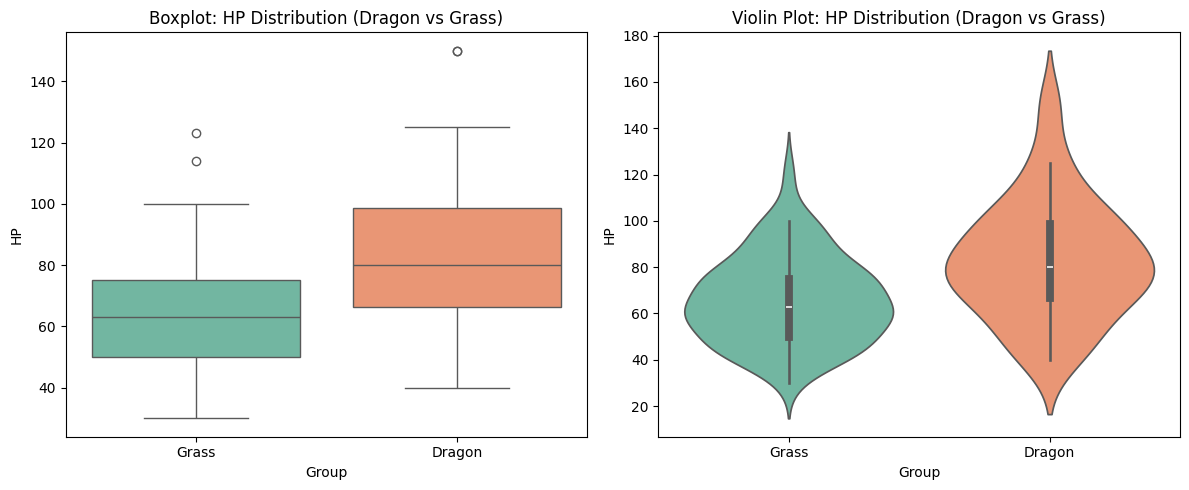

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a smaller dataframe with just Dragon and Grass Pokémon
subset = df[(df["Type 1"].isin(["Dragon","Grass"])) | (df["Type 2"].isin(["Dragon","Grass"]))].copy()
subset["Group"] = np.where(subset["Type 1"].eq("Dragon") | subset["Type 2"].eq("Dragon"),
                           "Dragon", "Grass")

plt.figure(figsize=(12,5))

# --- Boxplot ---
plt.subplot(1,2,1)
sns.boxplot(data=subset, x="Group", y="HP", palette="Set2")
plt.title("Boxplot: HP Distribution (Dragon vs Grass)")

# --- Violin plot ---
plt.subplot(1,2,2)
sns.violinplot(data=subset, x="Group", y="HP", palette="Set2", inner="box")
plt.title("Violin Plot: HP Distribution (Dragon vs Grass)")

plt.tight_layout()
plt.show()


**Challenge 2**

In this challenge, we will be working with california-housing data. The data can be found here:
- https://raw.githubusercontent.com/data-bootcamp-v4/data/main/california_housing.csv

In [20]:
df = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/california_housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


**We posit that houses close to either a school or a hospital are more expensive.**

- School coordinates (-118, 34)
- Hospital coordinates (-122, 37)

We consider a house (neighborhood) to be close to a school or hospital if the distance is lower than 0.50.

Hint:
- Write a function to calculate euclidean distance from each house (neighborhood) to the school and to the hospital.
- Divide your dataset into houses close and far from either a hospital or school.
- Choose the propper test and, with 5% significance, comment your findings.
 

In [21]:
def euclid_dist(lon1, lat1, lon2, lat2):
    return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)

# Landmarks
school   = (-118.0, 34.0)
hospital = (-122.0, 37.0)
threshold = 0.50  # “close” cutoff


In [22]:
PRICE_COL = "median_house_value"   # change here if your column name differs

# Distances to each landmark
d_school   = euclid_dist(df["longitude"], df["latitude"], *school)
d_hospital = euclid_dist(df["longitude"], df["latitude"], *hospital)

# Minimum distance to either school or hospital
d_min = np.minimum(d_school, d_hospital)

# Boolean mask: close to either if min distance < threshold
is_close = d_min < threshold

# Price arrays
price_close = df.loc[is_close, PRICE_COL].dropna()
price_far   = df.loc[~is_close, PRICE_COL].dropna()

len(price_close), len(price_far), price_close.mean(), price_far.mean()


(6829, 10171, 246951.98213501245, 180678.44105790975)

In [23]:
# Welch t-test (independent samples, unequal variances)
t_stat, p_two = stats.ttest_ind(price_close, price_far, equal_var=False)

# One-tailed p for alternative mean(close) > mean(far)
diff = price_close.mean() - price_far.mean()
p_one = p_two/2 if diff > 0 else 1 - p_two/2

print(f"n (close, far): {len(price_close)}, {len(price_far)}")
print(f"Mean price (close, far): {price_close.mean():.0f}, {price_far.mean():.0f}")
print(f"Welch t = {t_stat:.3f}")
print(f"One-tailed p (close > far) = {p_one:.4g}")

alpha = 0.05
print("Decision @ 5%:",
      "Reject H0 — evidence close homes are more expensive"
      if (p_one < alpha and diff > 0) else
      "Fail to reject H0 — not enough evidence close homes are more expensive")


n (close, far): 6829, 10171
Mean price (close, far): 246952, 180678
Welch t = 37.992
One-tailed p (close > far) = 1.503e-301
Decision @ 5%: Reject H0 — evidence close homes are more expensive
